In [1]:
import numpy as np
import scipy.sparse as sp
import matplotlib.pyplot as plt

import time

In [2]:
Id, Sx, Sz = sp.csr_matrix(np.identity(2)), sp.csr_matrix(np.array([[0, 1], [1, 0]])), sp.csr_matrix(np.array([[1, 0], [0, -1]]))

In [3]:
def gen_sz_list(L):
    sz_list = []
    for j in range(L):
        full = 1
        for i in range(L):
            full = sp.kron(full, Id, format='csr') if i!=j else sp.kron(full, Sz, format='csr')
        sz_list.append(full)

    return sz_list


def gen_sx_list(L):
    sx_list = []
    for j in range(L):
        full = 1
        for i in range(L):
            full = sp.kron(full, Id, format='csr') if i!=j else sp.kron(full, Sx, format='csr')
        sx_list.append(full)

    return sx_list

In [4]:
def gen_hamiltonian(sx_list, sz_list, g, J=1):

    L = len(sx_list)
    assert L == len(sz_list)

    H = 0
    for j in range(L-1):

        H += sx_list[j] * sx_list[j+1]
        
    H += sx_list[L-1] * sx_list[0]
    H = - J*H - g*sum(sz_list)

    return H

In [5]:
gen_hamiltonian(gen_sx_list(2), gen_sz_list(2), g=0.1, J=1).toarray()

array([[-0.2,  0. ,  0. , -2. ],
       [ 0. ,  0. , -2. ,  0. ],
       [ 0. , -2. ,  0. ,  0. ],
       [-2. ,  0. ,  0. ,  0.2]])

In [6]:
L = 12
H_sparse = gen_hamiltonian(gen_sx_list(L), gen_sz_list(L), g=0.1)
H = H_sparse.toarray()

start = time.time()
w, v = sp.linalg.eigsh(H_sparse, k=1, which='SA')
print('sparse: ', time.time() - start)

start = time.time()
w, v = np.linalg.eigh(H)
print('full: ', time.time() - start)

sparse:  0.022933006286621094
full:  13.452436208724976


In [7]:
L_list = [6, 8, 10, 12]
g_list = np.linspace(0, 2, 20)

L_to_C = {}
for L in L_list:

    sx_list, sz_list = gen_sx_list(L), gen_sz_list(L)
    C_list = []
    for g in g_list:

        H = gen_hamiltonian(sx_list, sz_list, g=g)
        w, v = sp.linalg.eigsh(H, k=3, which='SA')
        v0 = v[:, 0]
        C = np.inner(v0, sx_list[0] * sx_list[L//2] * v0)
        C_list.append(C)

    L_to_C[L] = C_list

In [8]:
L_list = [6, 8, 10, 12]
g_list = np.linspace(0, 2, 20)

data = dict()
for L in L_list:

    sx_list, sz_list = gen_sx_list(L), gen_sz_list(L)
    data[L] = dict()
    C_list, E1_list, E2_list = list(), list(), list()
    for g in g_list:

        H = gen_hamiltonian(sx_list, sz_list, g=g)
        w, v = sp.linalg.eigsh(H, k=3, which='SA')

        E1, E2 = w[1] - w[0],  w[2] - w[0]
        E1_list.append(E1), E2_list.append(E2)

        v0 = v[:, 0]
        C = np.inner(v0, sx_list[0] * sx_list[L//2] * v0)
        C_list.append(C)

    data[L]['E1'] = E1_list
    data[L]['E2'] = E2_list
    data[L]['C'] = C_list

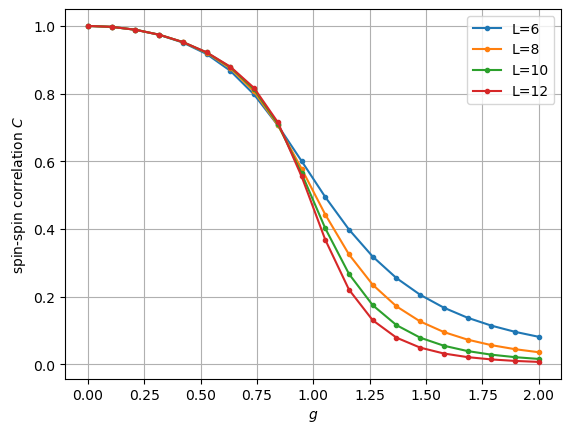

In [9]:
fig, ax = plt.subplots(1, 1)
for L in L_list:
    ax.plot(g_list, data[L]['C'], marker='.', label='L={L:d}'.format(L=L))
ax.set_xlabel("$g$"), ax.set_ylabel("spin-spin correlation $C$"), ax.grid(), ax.legend();

Phase transition at $g=1$. For $g<1$

* spins become (parallel) correlated over large distances

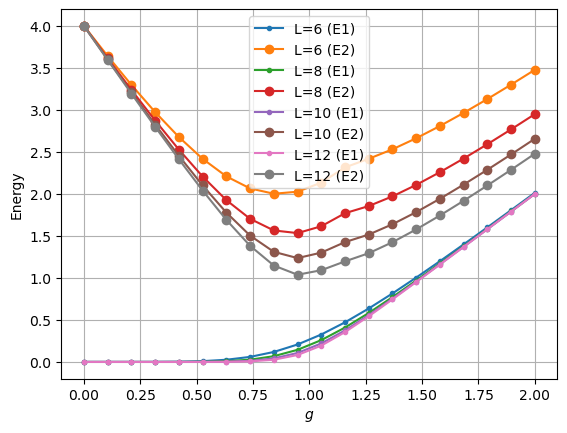

In [10]:
fig, ax = plt.subplots(1, 1)
for L in L_list:
    ax.plot(g_list, data[L]['E1'], marker='.', label='L={L:d} (E1)'.format(L=L))
    ax.plot(g_list, data[L]['E2'], marker='o', label='L={L:d} (E2)'.format(L=L))
ax.set_xlabel("$g$"), ax.set_ylabel("Energy"), ax.grid(), ax.legend();
fig.subplots_adjust(wspace=0.5)

Phase transition at $g=1$. For $g<1$

* ground and first excited state become degenerated for all system sizes
* energy between ground and second excited state become independent of system size